In [1]:
import sys
import os.path as op
module_path = op.abspath(op.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from scipy.io import loadmat
import hypyp
import mne
import numpy as np

from data_analysis.functions_connectivity import \
    plot_connectivity_matrix
from data_analysis.functions_preprocessing import \
    (combine_raws, split_raws, combine_epochs, split_epochs,
     preprocess_single_sub, load_ica, load_autoreject)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 unused import

subject_dir = "/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/"
result_dir = "/net/store/nbp/projects/hyperscanning/study_project/results/"
behav_path = "/net/store/nbp/projects/hyperscanning/study_project/dirk/NBP_Hyperscanning/data_analysis/Behavioural_Analysis/BehaviouralData"


In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /net/store/nbp/projects/hyperscanning/study_project/programming_tools/miniconda3/envs/hyperscanning/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /net/store/nbp/projects/hyperscanning/study_project

get two raw object to extract channel information (Since we use the same setup for all channels, the subject number doesn't matter).

In [2]:
subj = "204"

subs_path = subject_dir + "sub-{0}/eeg/sub-{0}_task-hyper_eeg.fif".format(subj)

combined_raw = mne.io.read_raw_fif(subs_path, preload=True).crop(tmin=0, tmax=1)

# split the subjects and delete the raw file
raws = split_raws(combined_raw)

for i, _ in enumerate(raws):
    # set the EEG Montage. We use 64 chans from the standard 10-05 system.
    montage = mne.channels.make_standard_montage("standard_1005")
    raws[i].set_montage(montage)
    raws[i].pick_types(eeg=True)


Opening raw data file /net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-204/eeg/sub-204_task-hyper_eeg.fif...


<ipython-input-2-f1177bba373a>:5: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/hyperscanning-2.0/mne_data/sourcedata/sub-204/eeg/sub-204_task-hyper_eeg.fif) does not conform to MNE naming conventions. All raw files should end with raw.fif, raw_sss.fif, raw_tsss.fif, raw.fif.gz, raw_sss.fif.gz, raw_tsss.fif.gz or _meg.fif
  combined_raw = mne.io.read_raw_fif(subs_path, preload=True).crop(tmin=0, tmax=1)


Isotrak not found
    Range : 0 ... 3537048 =      0.000 ...  3454.148 secs
Ready.
Reading 0 ... 3537048  =      0.000 ...  3454.148 secs...
EEG channel type selected for re-referencing
Applying a custom EEG reference.
EEG channel type selected for re-referencing
Applying a custom EEG reference.


In [3]:
freqs = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", "204_early"))[0].freqs
freqs

Reading /net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/204_early ...


<ipython-input-3-aef9a0fea3d9>:1: RuntimeWarning: This filename (/net/store/nbp/projects/hyperscanning/study_project/results/phase_angles/204_early) does not conform to MNE naming conventions. All tfr files should end with -tfr.h5 or _tfr.h5
  freqs = mne.time_frequency.read_tfrs(op.join(result_dir, "phase_angles", "204_early"))[0].freqs


Not setting metadata


array([ 4.        ,  4.54342965,  5.16068826,  5.86180602,  6.65817582,
        7.56273837,  8.59019244,  9.75723377, 11.08282631, 12.58851043,
       14.2987529 , 16.24134449, 18.44785154, 20.95412894, 23.8009027 ,
       27.03443178, 30.70725976, 34.87906866, 39.61764871, 45.        ])

load the ISPC

In [4]:
subj = "202"
cond = "early"

ispcs = loadmat(op.join(result_dir, "ispc_matrices", str(subj) + "_" + cond + ".mat"))[cond]

plot it

In [5]:
inter_brain = ispcs[0, :64, 64:, 0]

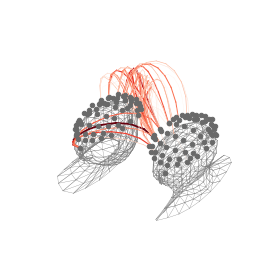

<Axes3DSubplot:>

In [6]:
hypyp.viz.viz_3D_inter(raws[0], raws[1], ispcs[0, :64, 64:, 0], threshold='auto', steps=10, lab=False)

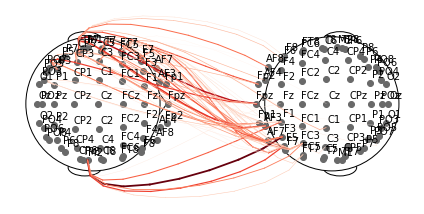

<AxesSubplot:>

In [7]:
hypyp.viz.viz_2D_topomap_inter(raws[0], raws[1], inter_brain, threshold='auto', steps=10, lab=True)

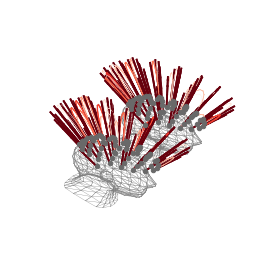

<Axes3DSubplot:>

In [8]:
hypyp.viz.viz_3D_intra(raws[0], raws[1],
                       C1= ispcs[0, :64, :64, 0],
                       C2= ispcs[0, 64:, 64:, 0],
                       threshold='auto',
                       steps=10,
                       lab=False)

# ISPC AVERAGES

In [9]:
# get the average ISPCs
subs = ["202", "203", "204", "205", "206", "207", "208", "209", "211", "212"]
conds = ["early", "late"]

avg_ispc = {"early":np.zeros([128, 128, 20]), "late":np.zeros([128, 128, 20])}
for cond in conds:
    for subj in subs:
        ispcs = loadmat(op.join(result_dir, "ispc_matrices", str(subj) + "_" + cond + ".mat"))[cond]
        intra_sub_avg = np.mean(ispcs, axis=0)
        
        # add to sum
        avg_ispc[cond] += intra_sub_avg

# divide by the number of subjects do get the average
avg_ispc["early"] /= len(subs)
avg_ispc["late"] /= len(subs)

Inter brain connectivity for early epochs

In [10]:
def get_thresh(con_arr, n_connections):
    """Get the threshold to show n connections in the data."""
    flats = np.reshape(con_arr, newshape=-1)
    flats = flats[np.argsort(flats)[-n_connections:]]
    return flats[0]

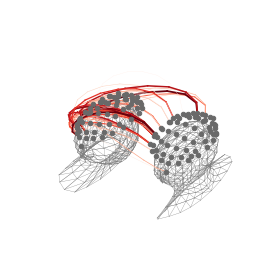

[ 4.          4.54342965  5.16068826  5.86180602  6.65817582  7.56273837
  8.59019244  9.75723377 11.08282631 12.58851043 14.2987529  16.24134449
 18.44785154 20.95412894 23.8009027  27.03443178 30.70725976 34.87906866
 39.61764871 45.        ]
Freq =  45.00000000000001
Thresh =  0.2623134529118656


In [30]:
freq_idx = -1
n_connections = 50
early = avg_ispc["early"][:64, 64:, freq_idx]

constant_thresh = get_thresh(early, n_connections)

hypyp.viz.viz_3D_inter(raws[0], raws[1], early,
                       threshold=constant_thresh, steps=10, lab=False)

print(freqs)
print("Freq = ", freqs[freq_idx])
print("Thresh = ", constant_thresh)

Inter brain connectivity for late epochs

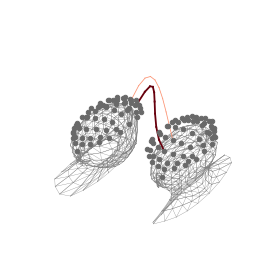

<Axes3DSubplot:>

In [31]:
late = avg_ispc["late"][:64, 64:, freq_idx]

hypyp.viz.viz_3D_inter(raws[0], raws[1], late, threshold=constant_thresh, steps=10, lab=False)

Early epochs

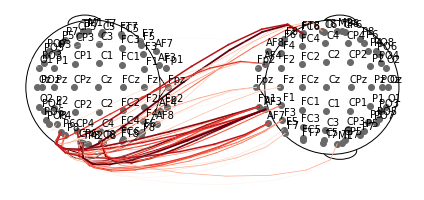

<AxesSubplot:>

In [32]:
hypyp.viz.viz_2D_topomap_inter(raws[0], raws[1], early, threshold=constant_thresh, steps=10, lab=True)

Late epochs

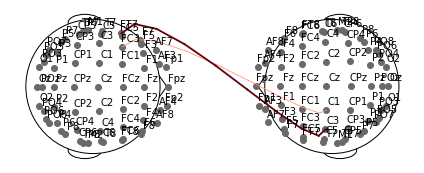

<AxesSubplot:>

In [33]:
hypyp.viz.viz_2D_topomap_inter(raws[0], raws[1], late, threshold=constant_thresh, steps=10, lab=True) 